# Sistemas de recomendación
### Carga de datos de Movie Lens

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("../datasets/ml-100k/u.data.csv", sep="\t", header=None)
df.columns = ["UserID", "ItemID", "Rating", "TimeStamp"]
df.head()

,UserID,ItemID,Rating,TimeStamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Analisis exploratorio de los ítems

In [4]:
import matplotlib.pyplot as plt

(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

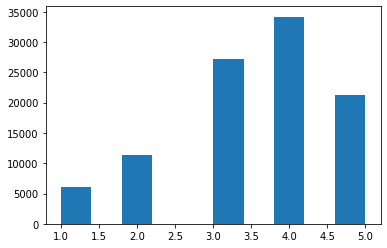

In [5]:
plt.hist(df.Rating)

(array([11459.,  5724., 19359.,  9315.,  9396., 10083.,  6175.,  9603.,
        10048.,  8838.]),
 array([8.74724710e+08, 8.76580903e+08, 8.78437096e+08, 8.80293288e+08,
        8.82149481e+08, 8.84005674e+08, 8.85861867e+08, 8.87718060e+08,
        8.89574252e+08, 8.91430445e+08, 8.93286638e+08]),
 <BarContainer object of 10 artists>)

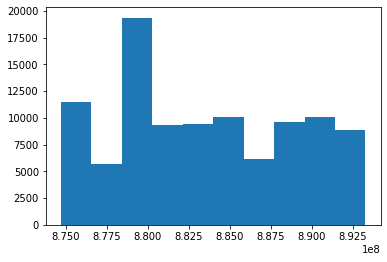

In [6]:
plt.hist(df.TimeStamp)

In [7]:
df.groupby(["Rating"])["UserID"].count()

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserID, dtype: int64

(array([1.146e+03, 2.490e+02, 1.390e+02, 6.700e+01, 3.800e+01, 2.400e+01,
        7.000e+00, 5.000e+00, 6.000e+00, 1.000e+00]),
 array([  1. ,  59.2, 117.4, 175.6, 233.8, 292. , 350.2, 408.4, 466.6,
        524.8, 583. ]),
 <BarContainer object of 10 artists>)

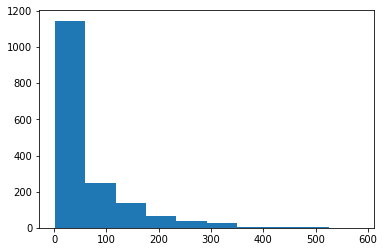

In [12]:
plt.hist(df.groupby(["ItemID"])["ItemID"].count())

### Representación en forma matricial

In [21]:
import numpy as np
n_users = df.UserID.unique().shape[0]
n_users

943

In [22]:
n_items = df.ItemID.unique().shape[0]
n_items

1682

In [23]:
ratings = np.zeros((n_users, n_items))

In [24]:
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

In [28]:
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [33]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0]*ratings.shape[1])
sparsity *= 100
print("Coeficiente de sparseidad: {:4.2f}%".format(sparsity))

Coeficiente de sparseidad: 6.30%


### Crear conjuntos de entrenamiento y validación

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
ratings_train, ratings_test = train_test_split(ratings, test_size=0.3, random_state=42)

In [37]:
ratings_train.shape

(660, 1682)

In [38]:
ratings_test.shape

(283, 1682)

### Filtro colaborativo basado en Usuarios
* Matriz de similaridad entre los usuarios (distancia del coseno).
* Predecir la valoración desconocida de un ítem *i* para un usuario activo *u* basandonos en la suma ponderada de todas las valoraciones del resto de los usuarios para dicho ítem.
* Recomendaremos los nuevos ítems a los usuarios según lo establecido en los pasos anteriores.

In [73]:
import numpy as np
import sklearn

In [74]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_train) 

In [75]:
sim_matrix.shape

(660, 660)

In [76]:
sim_matrix

array([[1.        , 0.17448349, 0.18009754, ..., 0.13331459, 0.17695593,
        0.21882481],
       [0.17448349, 1.        , 0.07993097, ..., 0.07175808, 0.09552622,
        0.05512655],
       [0.18009754, 0.07993097, 1.        , ..., 0.0191736 , 0.02233385,
        0.10310785],
       ...,
       [0.13331459, 0.07175808, 0.0191736 , ..., 1.        , 0.04853428,
        0.05142508],
       [0.17695593, 0.09552622, 0.02233385, ..., 0.04853428, 1.        ,
        0.1198022 ],
       [0.21882481, 0.05512655, 0.10310785, ..., 0.05142508, 0.1198022 ,
        1.        ]])

In [77]:
users_predictions = sim_matrix.dot(ratings_train) / np.array([np.abs(sim_matrix).sum(axis=1)]).T

In [78]:
users_predictions

array([[2.10259747e+00, 5.86975978e-01, 3.40264192e-01, ...,
        0.00000000e+00, 7.33611460e-03, 6.04379414e-03],
       [1.40999723e+00, 2.91863934e-01, 2.68085289e-01, ...,
        0.00000000e+00, 3.50378592e-03, 2.32963985e-03],
       [1.69014833e+00, 3.13648440e-01, 3.26127887e-01, ...,
        0.00000000e+00, 3.25391767e-03, 1.77210119e-03],
       ...,
       [1.73393747e+00, 4.06719333e-01, 3.21166908e-01, ...,
        0.00000000e+00, 2.71269625e-03, 9.00511411e-03],
       [2.34361031e+00, 8.10544770e-01, 4.73941025e-01, ...,
        0.00000000e+00, 1.01130066e-02, 9.66427605e-03],
       [2.36796969e+00, 5.98146138e-01, 3.85569804e-01, ...,
        0.00000000e+00, 6.39996638e-03, 5.37442746e-03]])

In [79]:
#Error cuadratico
from sklearn.metrics import mean_squared_error

In [154]:
def get_mse(preds, actuals):
    if preds.shape[0] != actuals.shape[0]:
        actuals = actuals.T
        
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [81]:
get_mse(users_predictions, ratings_train)

7.878218313143215

In [56]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_test)
users_predictions = sim_matrix.dot(ratings_test) / np.array([np.abs(sim_matrix).sum(axis=1)]).T
get_mse(users_predictions, ratings_test)

7.51355110112698

### Filtro colaborativo basado en los KNN

In [82]:
from sklearn.neighbors import NearestNeighbors

In [96]:
k = 3

In [97]:
neighbors = NearestNeighbors(k, 'cosine')

/home/alex/anaconda3/envs/Curso-ML-Python/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=3, radius=cosine as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [98]:
neighbors.fit(ratings_train)

NearestNeighbors(n_neighbors=3, radius='cosine')

In [99]:
top_k_distances, top_k_users = neighbors.kneighbors(ratings_train, return_distance=True)

In [100]:
top_k_distances.shape

(660, 3)

In [101]:
top_k_distances[0]

array([ 0.        , 41.71330723, 43.3474336 ])

In [102]:
top_k_users[0]

array([  0, 211,  16])

In [103]:
users_predicts_k = np.zeros(ratings_train.shape)
for i in range(ratings_train.shape[0]): # para cada usuario del conjunto de entrenamiento
    users_predicts_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i]) / np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T

In [104]:
users_predicts_k.shape

(660, 1682)

In [105]:
users_predicts_k

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.49462669, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [4.03816173, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [106]:
get_mse(users_predicts_k, ratings_train)

8.394685749753174

In [107]:
get_mse(users_predicts_k, ratings_test)

11.509662671215983

### Filtro colaborativo basado en Items

In [108]:
n_movies = ratings_train.shape[1]
n_movies

1682

In [110]:
neighbors = NearestNeighbors(n_movies, 'cosine')

In [111]:
neighbors.fit(ratings_train.T)

NearestNeighbors(n_neighbors=1682, radius='cosine')

In [114]:
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

In [115]:
top_k_distances.shape

(1682, 1682)

In [117]:
top_k_items.shape

(1682, 1682)

In [123]:
top_k_items

array([[   0,  120,  404, ...,  285,  312,  301],
       [   1,  575,  232, ...,  257,   99,   49],
       [   2,  742, 1094, ...,  180,   99,   49],
       ...,
       [1565, 1571, 1570, ...,  180,   99,   49],
       [1680, 1671, 1582, ...,  180,   99,   49],
       [1681, 1596, 1592, ...,  180,   99,   49]])

In [118]:
item_preds = ratings_train.dot(top_k_distances) / np.array([np.abs(top_k_distances).sum(axis=1)])

In [119]:
item_preds.shape

(660, 1682)

In [120]:
item_preds

array([[0.        , 0.31842643, 0.37009323, ..., 1.44850442, 1.4566397 ,
        1.54530823],
       [0.        , 0.0545379 , 0.06227954, ..., 0.20078701, 0.20112087,
        0.21332472],
       [0.        , 0.03522479, 0.04073126, ..., 0.18456903, 0.18654661,
        0.20076303],
       ...,
       [0.        , 0.08968346, 0.10313623, ..., 0.42050197, 0.4196067 ,
        0.45863507],
       [0.        , 0.25835756, 0.29918119, ..., 1.31043371, 1.32278067,
        1.41390683],
       [0.        , 0.07174777, 0.08538024, ..., 0.25535196, 0.25259645,
        0.26199652]])

In [121]:
get_mse(item_preds, ratings_train)

11.172565375125632

In [122]:
get_mse(item_preds, ratings_test)

11.876775601508902

In [139]:
movies_df = pd.read_csv("../datasets/ml-100k/u.item.csv", sep="|", header=None)
movies_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Filtrado colaborativo basado en KNN

In [140]:
k = 30
neighbors = NearestNeighbors(k, 'cosine')
neighbors.fit(ratings_train.T)
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

/home/alex/anaconda3/envs/Curso-ML-Python/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=30, radius=cosine as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [142]:
top_k_distances.shape

(1682, 30)

In [143]:
top_k_items[0]

array([  0, 120, 404, 116, 221, 150, 117, 180,   6, 741,  27,  94, 256,
       236, 124,  81,  24, 587, 227, 110, 234,  78, 203, 545,  70,  14,
        68, 596,  49, 143])

In [144]:
top_k_distances[0]

array([ 0.        , 53.12249994, 54.38749856, 55.50675635, 56.49778757,
       56.9473441 , 57.21013896, 57.81003373, 58.10335619, 58.16356248,
       58.19793811, 58.37807808, 58.70264049, 58.83876273, 58.97457079,
       59.52310476, 59.61543424, 59.84981203, 59.89156869, 59.94163828,
       60.15812497, 60.35726965, 60.37383539, 60.63002556, 60.86049622,
       61.11464636, 61.31883887, 61.37589103, 61.57109712, 61.80614856])

In [145]:
preds = np.zeros(ratings_train.T.shape)
for i in range(ratings_train.T.shape[0]):
    preds[i, :] = top_k_distances[i].dot(ratings_train.T[top_k_items][i]) / np.array([np.abs(top_k_distances[i]).sum(axis=0)]).T

/home/alex/anaconda3/envs/Curso-ML-Python/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [155]:
get_mse(preds, ratings_train)

8.733998550319365

In [147]:
preds.shape

(1682, 660)

In [148]:
ratings_train.shape

(660, 1682)

In [149]:
ratings_test.shape

(283, 1682)